In [ ]:
import os
import pandas as pd
import kagglehub
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import gc
from pathlib import Path

from tools import reduce_mem_usage

OVERWRITE = False

In [30]:
# Path to the cached dataset
cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")
data_path = os.path.join(cache_path, "mryanm/luflow-network-intrusion-detection-data-set/versions/240")
src_dir = os.getcwd()
combined_data_path = os.path.join(src_dir, os.pardir, "data", "luflow_combined.csv")

if not (os.path.exists(data_path) or os.path.exists(combined_data_path)) or OVERWRITE: # if either of the paths exist, don't download
    # Download latest version
    data_path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

if os.path.exists(combined_data_path) and not OVERWRITE:
    print(f"Combined data path: {combined_data_path}")
else:
    print(f"Data path: {data_path}")

Combined data path: /home/riley/networking_llm/src/../data/luflow_combined.csv


Data is in different folders seperated by year, month, and day. For ease of loading, I opted to combine these into a single csv.

In [31]:
def save_luflow(data_path, save_path):
    first_write = True  # Track if it's the first write to include headers

    # Load and combine each CSV
    for year in tqdm(sorted(os.listdir(data_path))):  # Sorting for consistency
        year_path = os.path.join(data_path, year)
        if os.path.isdir(year_path):
            for month in sorted(os.listdir(year_path)):
                month_path = os.path.join(year_path, month)
                if os.path.isdir(month_path):
                    for day in sorted(os.listdir(month_path)):
                        day_path = os.path.join(month_path, day)
                        if os.path.isdir(day_path):
                            for file in os.listdir(day_path):
                                if file.endswith(".csv"):
                                    full_path = os.path.join(day_path, file)

                                    # Read in chunks (adjust chunksize as needed)
                                    for chunk in pd.read_csv(full_path, chunksize=10_000):
                                        # Extract date info
                                        try:
                                            y, m, d = map(int, file.split(".")[:3])
                                            chunk["Year"] = y
                                            chunk["Month"] = m
                                            chunk["Day"] = d
                                            chunk['label'] = pd.Categorical(chunk['label']).codes
                                        except ValueError:
                                            print(f"Skipping malformed filename: {file}")
                                            continue

                                        # Append to file (write header only once)
                                        chunk.to_csv(save_path, mode='a', header=first_write, index=False)
                                        first_write = False  # Only write header in the first batch

    print(f"Finished merging CSVs into {save_path}")

if not os.path.exists(combined_data_path) or OVERWRITE:
    save_luflow(data_path, combined_data_path)
    # remove cache data_path
    os.system(f"rm -rf {data_path}")

In [32]:
data = pd.read_csv(combined_data_path, nrows=7_500_000)
data = reduce_mem_usage(data)
data.head()

Memory usage after optimization is: 443.46 MB
Decreased by 59.2%


/home/riley/networking_llm/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration,Year,Month,Day
0,7.500000,342,3679,786,9200.0,5.437500,2,2,6,786,57392.0,1592533725648144,1592533725632946,21860.917969,0,0.015198,2020,6,19
1,0.000000,0,0,786,55972.0,0.000000,1,1,6,49453,49493.0,1592533744644904,1592533744644904,0.000000,2,0.000000,2020,6,19
2,0.500000,15440,942,786,9300.0,2.203125,3,3,6,786,60512.0,1592533770936279,1592533770933553,36091.753906,0,0.002726,2020,6,19
3,20.217392,622,31010,786,9300.0,1.190430,23,5,6,786,60490.0,159253376770238,15925337672353,37640.355469,0,0.467041,2020,6,19
4,0.000000,0,0,786,59498.0,0.000000,1,1,6,786,9300.0,1592533772973114,1592533772973087,0.000000,0,0.000027,2020,6,19


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500000 entries, 0 to 7499999
Data columns (total 19 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float32
 1   bytes_in       int32  
 2   bytes_out      int32  
 3   dest_ip        int32  
 4   dest_port      float32
 5   entropy        float16
 6   num_pkts_out   int16  
 7   num_pkts_in    int16  
 8   proto          int8   
 9   src_ip         int32  
 10  src_port       float32
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float32
 14  label          int8   
 15  duration       float16
 16  Year           int16  
 17  Month          int8   
 18  Day            int8   
dtypes: float16(2), float32(4), int16(3), int32(4), int64(2), int8(4)
memory usage: 443.5 MB


In [34]:
data['Day'].value_counts()

Day
22    4204081
21     814816
20     770853
19     765360
23     637677
24     307213
Name: count, dtype: int64

The full dataset is too large to get description stats in a timely manner, so only inspecting a subset. NaN seen for some mean values due to overflow during summation, a consequence of downcasting as we've done.

In [35]:
data.dest_port = data.dest_port.fillna(-1).astype('int64')
data.src_port = data.src_port.fillna(-1).astype('int64')

data.describe()

/home/riley/networking_llm/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/riley/networking_llm/lib/python3.10/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riley/networking_llm/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/riley/networking_llm/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/riley/networking_llm/lib/python3.10/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riley/networking_llm/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid val

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration,Year,Month,Day
count,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7500000.0,7500000.0,7.500000e+06
mean,1.515988e+06,1.004937e+03,4.602249e+03,1.652941e+03,1.372595e+04,NaN,5.413012e+00,3.285689e+00,7.047596e+00,1.653160e+04,3.657185e+04,1.452405e+15,1.449253e+15,1.702605e+04,4.630831e-01,NaN,2020.0,6.0,2.154660e+01
std,4.287582e+07,4.473974e+03,6.907070e+03,8.210696e+03,1.606385e+04,0.000000e+00,1.262336e+01,1.204337e+01,3.440329e+00,3.993376e+04,1.859831e+04,4.286313e+14,4.328397e+14,6.049262e+04,7.219262e-01,0.000000e+00,0.0,0.0,1.217167e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,-1.000000e+00,1.592536e+10,1.592537e+10,0.000000e+00,0.000000e+00,0.000000e+00,2020.0,6.0,1.900000e+01
25%,0.000000e+00,0.000000e+00,4.700000e+01,7.860000e+02,1.900000e+03,2.035156e+00,1.000000e+00,0.000000e+00,6.000000e+00,7.860000e+02,1.430600e+04,1.592637e+15,1.592633e+15,9.736174e+02,0.000000e+00,4.297495e-05,2020.0,6.0,2.100000e+01
50%,0.000000e+00,0.000000e+00,3.670000e+02,7.860000e+02,9.200000e+03,3.089844e+00,3.000000e+00,1.000000e+00,6.000000e+00,7.860000e+02,4.446400e+04,1.592796e+15,1.592796e+15,8.341838e+03,0.000000e+00,1.149774e-04,2020.0,6.0,2.200000e+01
75%,4.500000e+00,2.700000e+02,8.688000e+03,7.860000e+02,9.200000e+03,4.832031e+00,7.000000e+00,3.000000e+00,6.000000e+00,8.048000e+03,4.910200e+04,1.592801e+15,1.592801e+15,2.654445e+04,1.000000e+00,2.381897e-02,2020.0,6.0,2.200000e+01
max,4.294967e+09,6.551200e+04,6.553400e+04,3.969980e+05,6.553500e+04,8.737500e+01,2.550000e+02,2.550000e+02,5.800000e+01,3.976510e+05,6.553500e+04,1.593015e+15,1.593015e+15,3.963484e+06,2.000000e+00,4.903125e+01,2020.0,6.0,2.400000e+01


0 = Benign, 1 = Malicious, 2 = Outlier

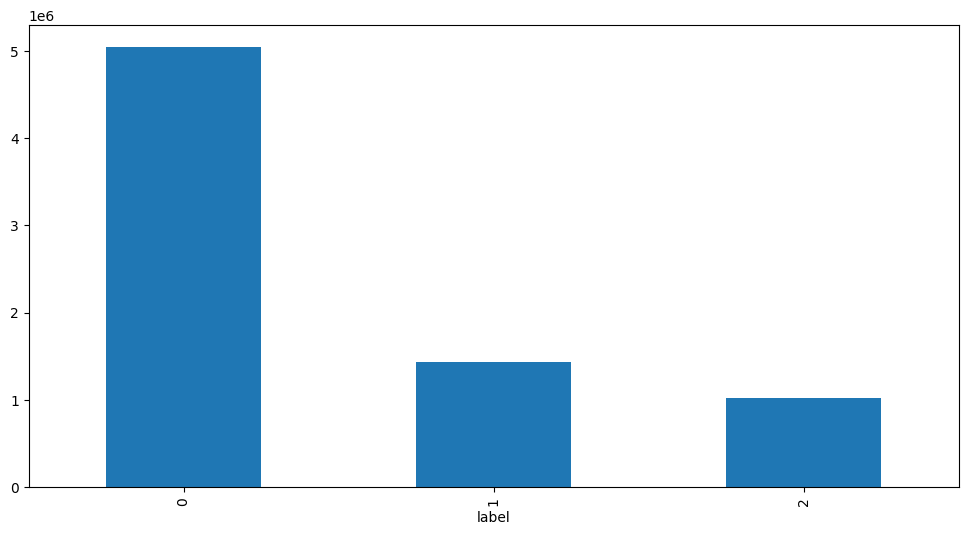

In [36]:
plt.figure(figsize=(12, 6))
data['label'].value_counts().plot(kind='bar')
plt.show()

Majority of flows use TCP (protocol 6)

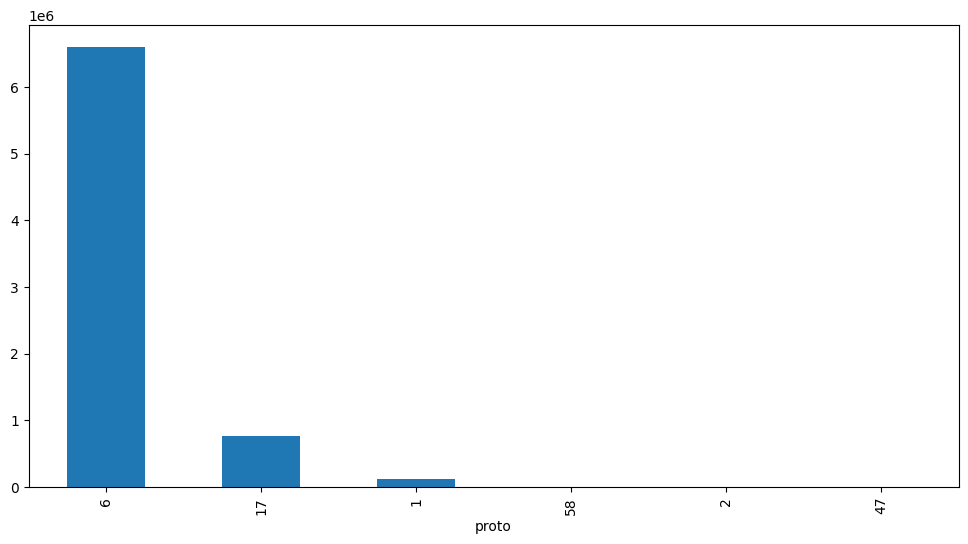

In [37]:
plt.figure(figsize=(12, 6))
data['proto'].value_counts().plot(kind='bar')
plt.show()

Columns to drop: src/dest_ip, time_start/end

In [38]:
data.drop(['src_ip', 'dest_ip', 'time_start', 'time_end'], axis=1, inplace=True)
target_col = 'label'
feature_cols = [col for col in data.columns if col != target_col]
del data
gc.collect()

8637

In [39]:
class LuFlowDataset(Dataset):
    def __init__(self, csv_path, feature_cols, target_col, chunk_size=1000):
        self.csv_path = Path(csv_path)
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.chunk_size = chunk_size
        # Read header once to verify columns
        self.header = pd.read_csv(self.csv_path, nrows=0).columns
        
        # Verify columns exist in the CSV
        print("Checking columns...")
        df_sample = pd.read_csv(self.csv_path, nrows=1)
        missing_cols = set(feature_cols + [target_col]) - set(df_sample.columns)
        if missing_cols:
            raise ValueError(f"Missing columns in CSV: {missing_cols}")
            
        print("Calculating total rows...")
        with open(csv_path, 'rb') as f:
            self.total_rows = sum(1 for _ in f) - 1  # -1 for header
            
    def _load_chunk(self, chunk_idx):
        # Load chunk directly using skiprows and nrows
        start_row = chunk_idx * self.chunk_size + 1  # +1 for header
        chunk = pd.read_csv(
            self.csv_path,
            skiprows=start_row,
            nrows=self.chunk_size,
            names=self.header  # Use the header we read earlie
        )
        return chunk[self.feature_cols].to_numpy(dtype=np.float32), chunk[self.target_col].to_numpy(dtype=np.float32).reshape(-1, 1)
        
    def __getitem__(self, index):
        chunk_idx = index // self.chunk_size
        row_idx = index % self.chunk_size
        
        features, target = self._load_chunk(chunk_idx)
        features = torch.from_numpy(features[row_idx])
        target = torch.from_numpy(target[row_idx])
        return features, target
        
    def __len__(self):
        return self.total_rows

# Usage
batch_size = 64
dataset = LuFlowDataset(
    csv_path=combined_data_path,
    feature_cols=feature_cols,
    target_col=target_col,
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Check performance
for batch in dataloader:
    inputs, labels = batch
    print(f"Sample input: {inputs[0]}")
    print(f"Sample label: {labels[0]}")
    print(inputs.shape, labels.shape)  # Debugging
    break  # Test one batch

Checking columns...
Calculating total rows...
Sample input: tensor([7.5000e+00, 3.4200e+02, 3.6790e+03, 9.2000e+03, 5.4367e+00, 2.0000e+00,
        2.0000e+00, 6.0000e+00, 5.7392e+04, 2.1861e+04, 1.5198e-02, 2.0200e+03,
        6.0000e+00, 1.9000e+01])
Sample label: tensor([0.])
torch.Size([64, 14]) torch.Size([64, 1])


From the GitHub https://github.com/ruzzzzz/luflow

#### src_ip:
The source IP address associated with the flow. This feature is anonymised to the corresponding Autonomous System

#### src_port:
The source port number associated with the flow.

#### dest_ip:
The destination IP address associated with the flow. The feature is also anonymised in the same manner as before.

#### dest_port:
The destination port number associated with the flow

#### protocol:
The protocol number associated with the flow. For example TCP is 6

#### bytes_in:
The number of bytes transmitted from source to destination

#### bytes_out:
The number of bytes transmitted from destination to source.

#### num_pkts_in:
The packet count from source to destination

#### num_pkts_out:
The packet count from destination to source

#### entropy:
The entropy in bits per byte of the data fields within the flow. This number ranges from 0 to 8.

#### total_entropy:
The total entropy in bytes over all of the bytes in the data fields of the flow

#### avg_ipt:
The mean of the inter-packet arrival times of the flow

#### time_start:
The start time of the flow in seconds since the epoch.

#### time_end:
The end time of the flow in seconds since the epoch

#### duration:
The flow duration time, with microsecond precision

#### label:
The label of the flow, as decided by Tangerine. Either benign, outlier, or malicious

Datasets from https://staff.itee.uq.edu.au/marius/NIDS_datasets/#RA6